# Best Location for Indian Restaurant in Toronto

In this project will try to find an optimal location to open an Indian restaurant. Specifically, this report will be targeted to stakeholders interested in opening an Indian Restaurant in Toronto. Finding a suitable location for Indian restaurants in major cities like Toronto proves to be a daunting task. Hence, customers can bolster their decisions using the descriptive and predictive capabilities of data science.

## Import necessary packages

In [1]:
!pip install bs4

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=73ef65f2ca5b6706326d3c6623bc9cf2960efe5d5a23970be3e8ee3a235b7b9e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/0a/9e/ba/20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca
Successfully built bs4


In [2]:
!conda install -c conda-forge folium=0.5.0 --yes 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-OpenCE

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2021.5.30          |   py37h89c1867_0         141 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.7             |          2_cp37m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    widgetsnbextension-3.5.1   |   py37h89c1867_4         1.8 MB  conda-forge
    ------------------------------------------------------------
        

In [3]:
pip install geopy

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize 
import folium 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


In [5]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

## Scrape and transform the data into pandas dataframe

In [6]:
data  = requests.get(url).text 
soup = BeautifulSoup(data,"lxml")
column_names = ['Postalcode','Borough','Neighborhood']
toronto_data = pd.DataFrame(columns = column_names)

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Group all neighborhoods with the same postal code

In [7]:
df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()


,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Get the latitude and the longitude coordinates of each neighborhood

Using csv file to create the Dataframe

In [9]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
df_toronto = pd.merge(df, df_data, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


We are going to work with only the boroughs that contain the word "Toronto".

In [11]:

df_toronto_data = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
4,M4M,East Toronto,Studio District,43.659526,-79.340923


In [12]:
print('The dataframe has {} borough and {} neighborhood.'.format(
        len(df_toronto_data['Borough'].unique()),
        df_toronto_data.shape[0]
    )
)

The dataframe has 7 borough and 39 neighborhood.


### Explore and cluster the neighborhoods in Toronto


#### Use geopy library to get the latitude and longitude values of Toronto.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [13]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto_data['Latitude'], df_toronto_data['Longitude'], df_toronto_data['Borough'], df_toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Foursquare


'The Foursquare Places API provides location based experiences with diverse information about venues, users, photos, and check-ins. The API supports real time access to places, Snap-to-Place that assigns users to specific locations, and Geo-tag.'(wikipedia)

Here we are using the explore api call and filtering the search only to find venues that are identified as restaurants.

In [15]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
radius=1000
LIMIT = 200 # A default Foursquare API limit value

Get the neighborhood's name.

In [16]:
df_toronto_data.loc[0, 'Neighborhood']

'The Beaches'

Get the neighborhood's latitude and longitude values.


In [17]:
neighborhood_latitude = df_toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


In [18]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
toronto_nearby_venues = getNearbyVenues(names=df_toronto_data['Neighborhood'],
                                   latitudes=df_toronto_data['Latitude'],
                                   longitudes=df_toronto_data['Longitude']
                               )
toronto_nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth East,43.685347,-79.338106,Danforth & Jones,43.684352,-79.334792,Intersection


In [20]:
map_venue = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_nearby_venues['Venue Latitude'], toronto_nearby_venues['Venue Longitude'], toronto_nearby_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venue)  
    
map_venue

In [21]:
df_toronto_venues = toronto_nearby_venues[toronto_nearby_venues["Venue Category"].str.contains("Restaurant")].reset_index(drop=True)
df_toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
1,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
2,"The Danforth West, Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant
3,"The Danforth West, Riverdale",43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant
4,"The Danforth West, Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677704,-79.350480,Greek Restaurant


In [22]:

# one hot encoding
df_toronto_onehot = pd.get_dummies(df_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_toronto_onehot['Neighborhood'] = df_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_toronto_onehot.columns[-1]] + list(df_toronto_onehot.columns[:-1])
df_toronto_onehot = df_toronto_onehot[fixed_columns]

df_toronto_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_toronto_onehot.shape

(373, 47)

In [24]:
toronto_grouped = df_toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Restaurant,Seafood Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berczy Park,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.076923,...,0.153846,0.153846,0.0,0.000000,0.0,0.076923,0.00,0.0,0.076923,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,...,0.500000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0
2,Central Bay Street,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,...,0.111111,0.000000,0.0,0.055556,0.0,0.055556,0.00,0.0,0.055556,0.0
3,Christie,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,...,0.500000,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0
4,Church and Wellesley,0.04,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.000000,...,0.120000,0.000000,0.0,0.200000,0.0,0.040000,0.04,0.0,0.000000,0.0


In [25]:
for i in toronto_grouped.columns:
    print(i,end=", ")

Neighborhood, American Restaurant, Asian Restaurant, Belgian Restaurant, Brazilian Restaurant, Cajun / Creole Restaurant, Caribbean Restaurant, Chinese Restaurant, Colombian Restaurant, Comfort Food Restaurant, Cuban Restaurant, Doner Restaurant, Dumpling Restaurant, Eastern European Restaurant, Ethiopian Restaurant, Falafel Restaurant, Fast Food Restaurant, Filipino Restaurant, French Restaurant, German Restaurant, Gluten-free Restaurant, Greek Restaurant, Indian Restaurant, Italian Restaurant, Japanese Restaurant, Korean Restaurant, Latin American Restaurant, Malay Restaurant, Mediterranean Restaurant, Mexican Restaurant, Middle Eastern Restaurant, Modern European Restaurant, Molecular Gastronomy Restaurant, Moroccan Restaurant, New American Restaurant, Portuguese Restaurant, Ramen Restaurant, Restaurant, Seafood Restaurant, Sri Lankan Restaurant, Sushi Restaurant, Taiwanese Restaurant, Thai Restaurant, Theme Restaurant, Tibetan Restaurant, Vegetarian / Vegan Restaurant, Vietnamese R

In [26]:
toronto_grouped.shape

(32, 47)

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [28]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Seafood Restaurant,Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Eastern European Restaurant,Comfort Food Restaurant,Moroccan Restaurant,Greek Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,Central Bay Street,Italian Restaurant,Japanese Restaurant,Restaurant,Portuguese Restaurant,Falafel Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Middle Eastern Restaurant,Modern European Restaurant
3,Christie,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,Church and Wellesley,Sushi Restaurant,Japanese Restaurant,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,American Restaurant,Mexican Restaurant,Theme Restaurant,Thai Restaurant,Indian Restaurant


### Clustering Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [29]:

# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 3, 0, 0, 0, 4, 0, 0], dtype=int32)

In [30]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(inplace=True)
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0.0,Greek Restaurant,Italian Restaurant,Restaurant,Caribbean Restaurant,Indian Restaurant,Japanese Restaurant,American Restaurant,Sushi Restaurant,Tibetan Restaurant,Sri Lankan Restaurant
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0.0,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
4,M4M,East Toronto,Studio District,43.659526,-79.340923,0.0,American Restaurant,Seafood Restaurant,Comfort Food Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Italian Restaurant,Thai Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant
7,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0.0,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
8,M4S,Central Toronto,Davisville,43.704324,-79.388790,0.0,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Seafood Restaurant,Greek Restaurant,Thai Restaurant,Brazilian Restaurant,Eastern European Restaurant,Asian Restaurant


In [31]:
 
toronto_merged = toronto_merged.astype({'Cluster Labels':int})
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Italian Restaurant,Restaurant,Caribbean Restaurant,Indian Restaurant,Japanese Restaurant,American Restaurant,Sushi Restaurant,Tibetan Restaurant,Sri Lankan Restaurant
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
4,M4M,East Toronto,Studio District,43.659526,-79.340923,0,American Restaurant,Seafood Restaurant,Comfort Food Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Italian Restaurant,Thai Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant
7,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
8,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Seafood Restaurant,Greek Restaurant,Thai Restaurant,Brazilian Restaurant,Eastern European Restaurant,Asian Restaurant


#### visualize the resulting clusters

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,East Toronto,0,Greek Restaurant,Italian Restaurant,Restaurant,Caribbean Restaurant,Indian Restaurant,Japanese Restaurant,American Restaurant,Sushi Restaurant,Tibetan Restaurant,Sri Lankan Restaurant
3,East Toronto,0,Italian Restaurant,Sushi Restaurant,Fast Food Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant
4,East Toronto,0,American Restaurant,Seafood Restaurant,Comfort Food Restaurant,Latin American Restaurant,Middle Eastern Restaurant,Italian Restaurant,Thai Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant
7,Central Toronto,0,Fast Food Restaurant,Chinese Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant
8,Central Toronto,0,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Seafood Restaurant,Greek Restaurant,Thai Restaurant,Brazilian Restaurant,Eastern European Restaurant,Asian Restaurant
10,Central Toronto,0,Vietnamese Restaurant,Sushi Restaurant,Restaurant,American Restaurant,Thai Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant
12,Downtown Toronto,0,Italian Restaurant,Restaurant,Sri Lankan Restaurant,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Japanese Restaurant,American Restaurant,Thai Restaurant,Taiwanese Restaurant
13,Downtown Toronto,0,Sushi Restaurant,Japanese Restaurant,Restaurant,Fast Food Restaurant,Mediterranean Restaurant,American Restaurant,Mexican Restaurant,Theme Restaurant,Thai Restaurant,Indian Restaurant
14,Downtown Toronto,0,French Restaurant,Mexican Restaurant,Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
15,Downtown Toronto,0,Japanese Restaurant,Italian Restaurant,Ramen Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Chinese Restaurant,Ethiopian Restaurant,Mexican Restaurant,Modern European Restaurant,New American Restaurant


#### Cluster 2

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Central Toronto,1,Sushi Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


#### Cluster 3

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,2,Fast Food Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Greek Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant


#### Cluster 4

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Downtown Toronto,3,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
34,West Toronto,3,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


#### Cluster 5

In [37]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Central Toronto,4,Middle Eastern Restaurant,Indian Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
32,West Toronto,4,Middle Eastern Restaurant,Vietnamese Restaurant,Dumpling Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


### Cluster Visualisations

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [39]:
clusterdata = pd.merge(df_toronto_onehot.groupby('Neighborhood').sum(),toronto_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0,1,2,3,4
American Restaurant,19,0,0,0,0
Asian Restaurant,10,0,0,0,0
Belgian Restaurant,2,0,0,0,0
Brazilian Restaurant,2,0,0,0,0
Cajun / Creole Restaurant,1,0,0,0,0


### Analysing Clusters

In [40]:
import seaborn as sns

In [41]:
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

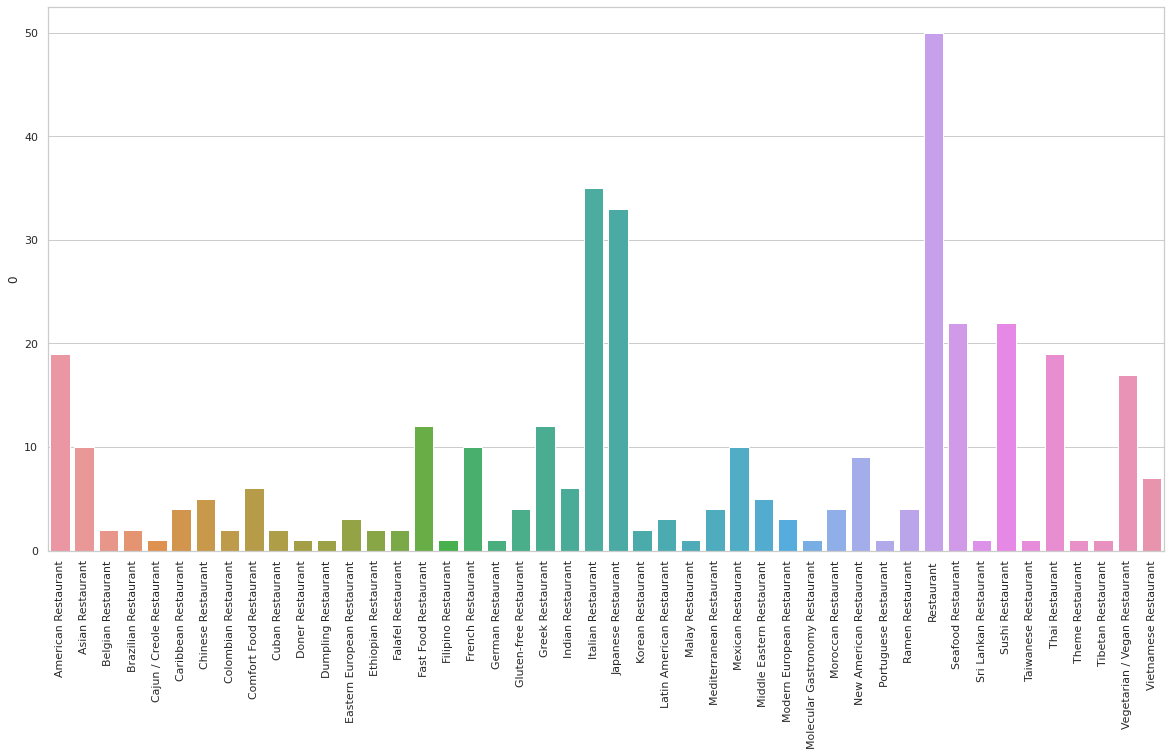

In [42]:
plot_bar(0)

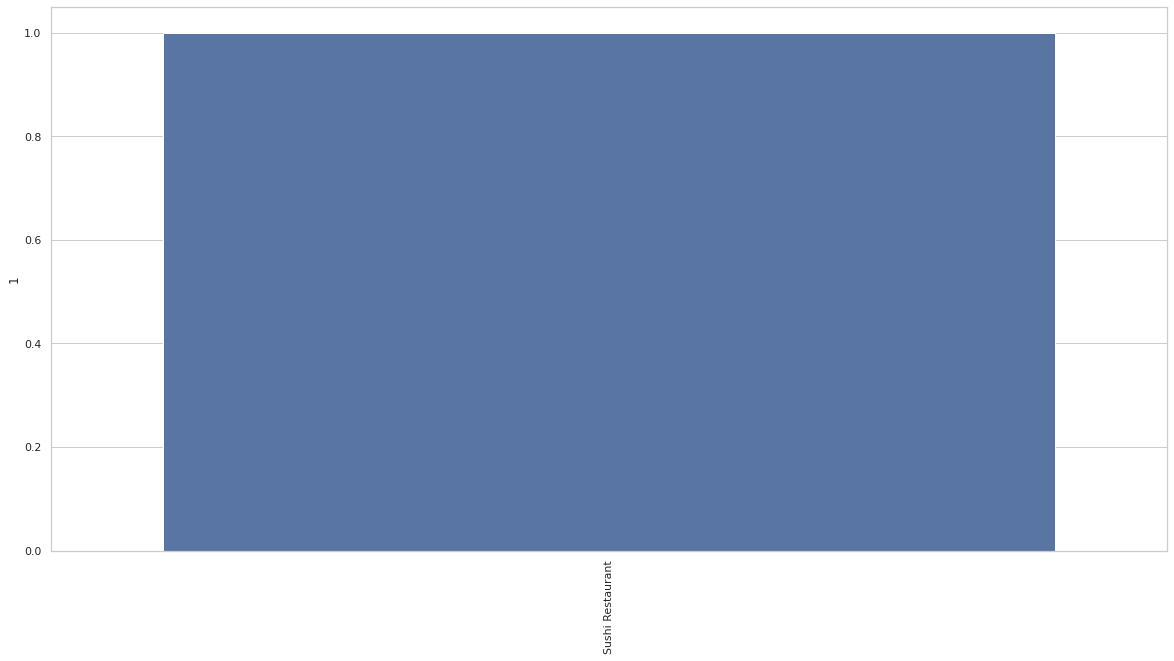

In [43]:
plot_bar(1)

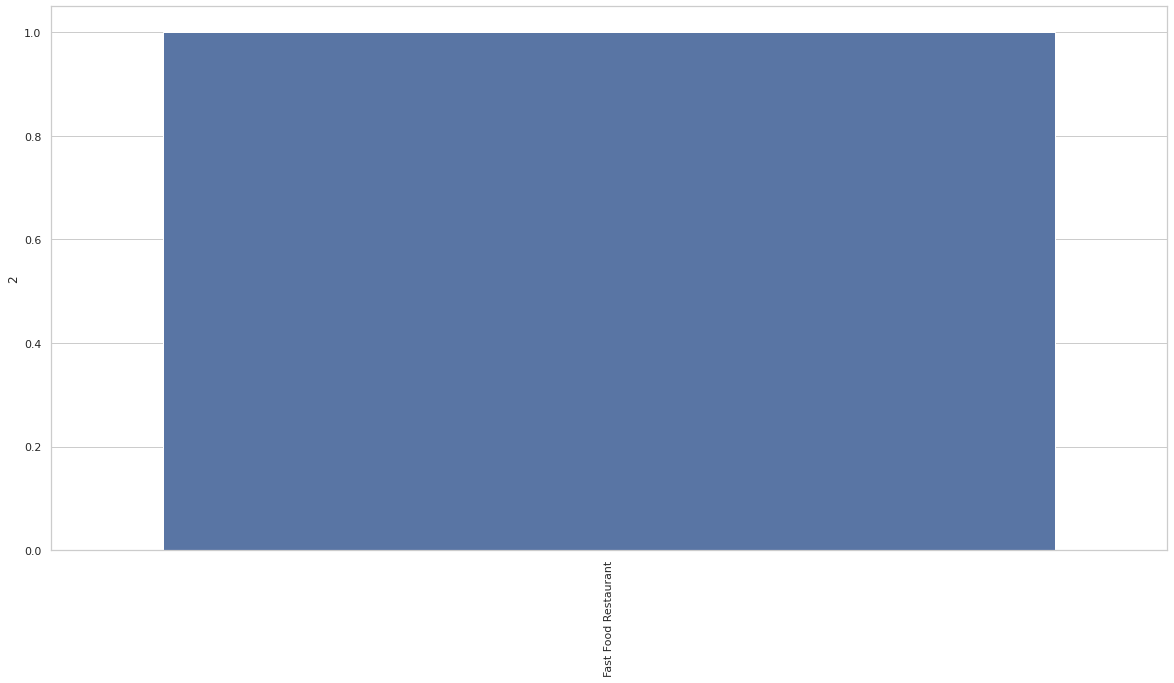

In [44]:
plot_bar(2)

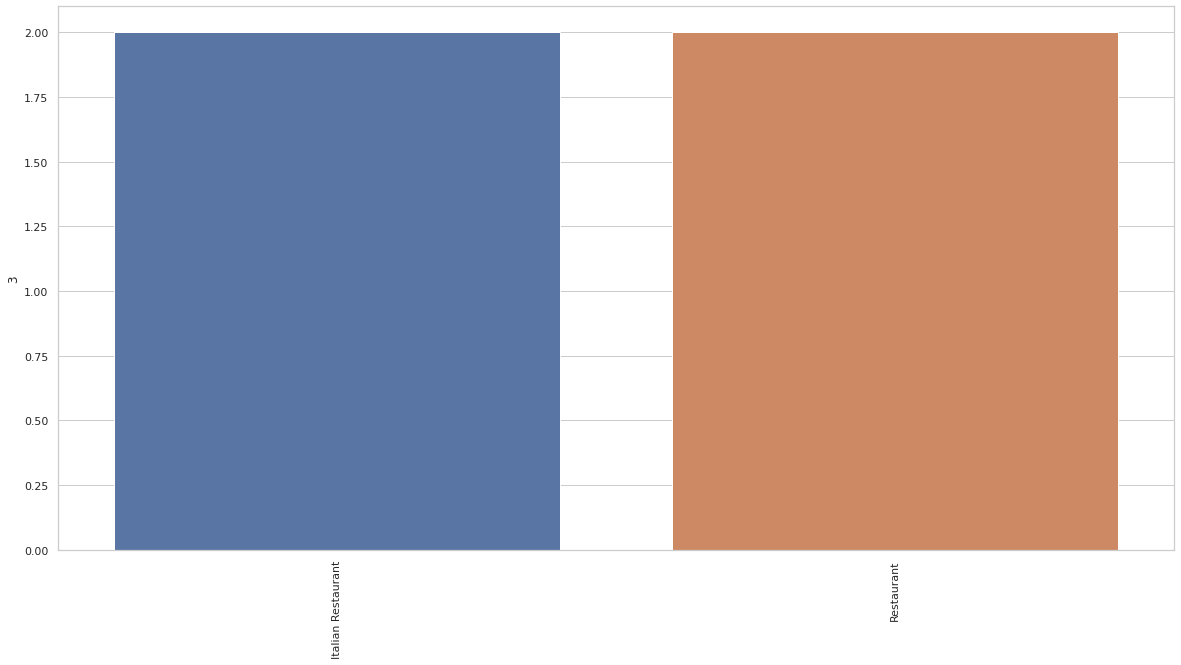

In [45]:
plot_bar(3)

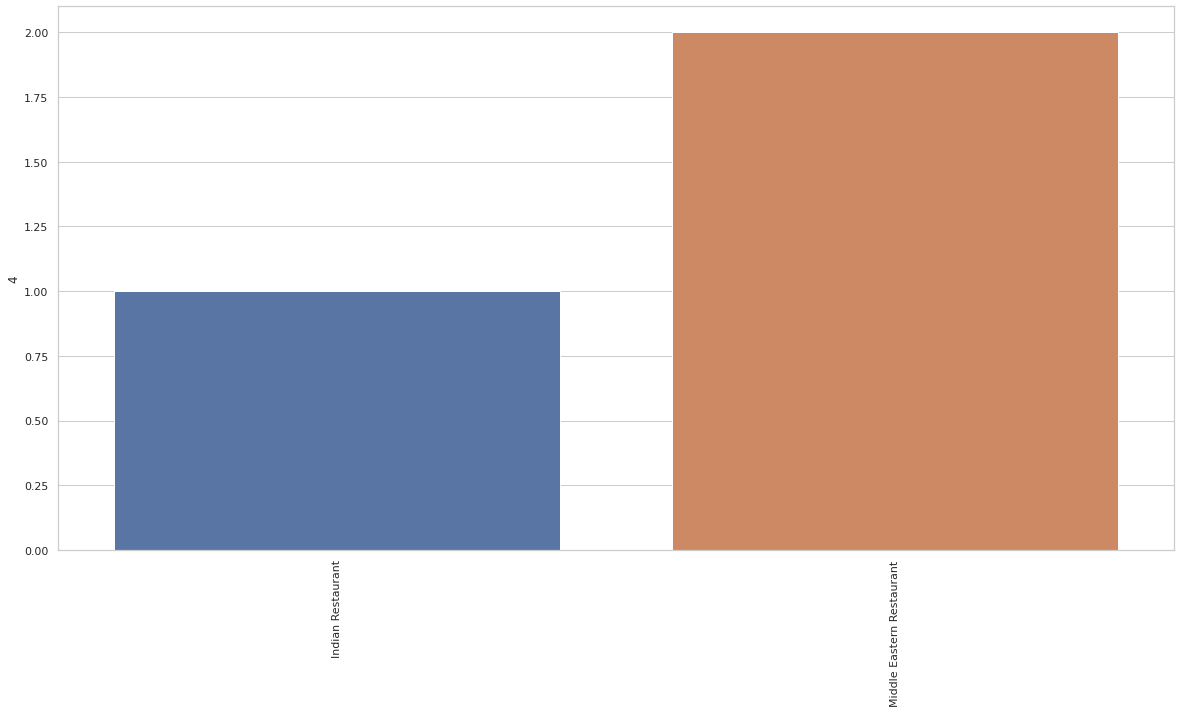

In [46]:
plot_bar(4)

Analysing the bar graphs we can clearly see that clusters 0 and 2 have a high demand for Indian Restaurants

In [69]:
forheatmap=df_toronto_venues.copy()
forheatmap=pd.merge(forheatmap,toronto_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
forheatmap.drop(forheatmap[~forheatmap['Cluster Labels'].isin([0,5])].index, inplace=True)

In [70]:
forheatmap.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
0,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,0
1,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant,0
2,"The Danforth West, Riverdale",43.679557,-79.352188,Mezes,43.677962,-79.350196,Greek Restaurant,0
3,"The Danforth West, Riverdale",43.679557,-79.352188,7 Numbers,43.677062,-79.353934,Italian Restaurant,0
4,"The Danforth West, Riverdale",43.679557,-79.352188,Messini Authentic Gyros,43.677704,-79.350480,Greek Restaurant,0


In [71]:
from folium.plugins import HeatMap

In [50]:
#heat map of all restaurants in selected Neighborhoods
res_heat = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forheatmap['Venue Latitude'],forheatmap['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat)
for lat, lng, label in zip(forheatmap['Neighborhood Latitude'], forheatmap['Neighborhood Longitude'], forheatmap['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat)
res_heat

In [72]:
forindres = forheatmap[forheatmap['Venue Category']=='Indian Restaurant']

# heat map for Indian Restaurants in the selected Neighborhoods
res_heat_ind = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forindres['Venue Latitude'],forindres['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat_ind)
for lat, lng, label in zip(forindres['Neighborhood Latitude'], forindres['Neighborhood Longitude'], forindres['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat_ind)
res_heat_ind

Removing all neighborhoods with the following conditions:

Number of Indian restaurants >30%

Number of all restaurants >60%

'%' here refers to percentile

In [73]:
count_all = forheatmap[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.6*len(count_all))
print(count_all.iloc[target_count])
count_all.drop(count_all[count_all.Venue.values>7].index,inplace=True)
count_all.columns=['all count']
count_all.head()

Venue    17
Name: The Danforth West, Riverdale, dtype: int64


,all count
Neighborhood,
Enclave of M4L,2
"Regent Park, Harbourfront",3
"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park",4
"Parkdale, Roncesvalles",4
North Toronto West,4


In [74]:
count_ind = forheatmap[forheatmap['Venue Category']=="Indian Restaurant"][['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.3*len(count_ind))
print(count_ind.iloc[target_count])
count_ind.drop(count_ind[count_ind.Venue.values>1].index,inplace=True)
count_ind.columns = ['ind count']
count_ind.head()

Venue    1
Name: Church and Wellesley, dtype: int64


,ind count
Neighborhood,
Central Bay Street,1
Church and Wellesley,1
Davisville,1
"Harbourfront East, Union Station, Toronto Islands",1
"St. James Town, Cabbagetown",1


In [75]:
lowdensity = count_all.join(count_ind)
lowdensity.index.values

array(['Enclave of M4L', 'Regent Park, Harbourfront',
       'Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park',
       'Parkdale, Roncesvalles', 'North Toronto West',
       'India Bazaar, The Beaches West', 'University of Toronto, Harbord',
       'High Park, The Junction South'], dtype=object)

In [76]:
temp_recommend = df_toronto_data.copy()
temp_recommend.drop(temp_recommend[~temp_recommend['Neighborhood'].isin(lowdensity.index.values)].index, inplace=True)
temp_recommend.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
3,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
7,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
10,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049
14,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
26,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049


We will add the last constraint i.e the neighborhood should be close to popular neighborhoods

In [77]:
#most popular neighborhoods
top_nei = df_toronto_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head(3).index.values
top_nei

array(['First Canadian Place, Underground city',
       'Commerce Court, Victoria Hotel',
       'Toronto Dominion Centre, Design Exchange'], dtype=object)

In [78]:
toplatlng = df_toronto_data[['Neighborhood','Latitude','Longitude']][df_toronto_data['Neighborhood'].isin(top_nei)].reset_index()
toplatlng

,index,Neighborhood,Latitude,Longitude
0,21,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576
1,22,"Commerce Court, Victoria Hotel",43.648198,-79.379817
2,30,"First Canadian Place, Underground city",43.648429,-79.382280


In [79]:
from math import sin, cos, sqrt, atan2, radians

def distanceInKM(la1,lo1,la2,lo2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dis = R * c
    return round(dis,4)

print("Result:", distanceInKM(toplatlng.iloc[2]['Latitude'],toplatlng.iloc[2]['Longitude'],toplatlng.iloc[0]['Latitude'],toplatlng.iloc[0]['Longitude']))

Result: 0.1504


In [80]:
temp_recommend.reset_index(inplace=True)


In [81]:
temp_recommend.drop(columns=['index','Borough'], inplace=True)

In [82]:
temp_recommend.head()

,PostalCode,Neighborhood,Latitude,Longitude
0,M4L,"India Bazaar, The Beaches West",43.668999,-79.315572
1,M4R,North Toronto West,43.715383,-79.405678
2,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049
3,M5A,"Regent Park, Harbourfront",43.654260,-79.360636
4,M5S,"University of Toronto, Harbord",43.662696,-79.400049


In [83]:
for i in toplatlng.index:
    temp_recommend[toplatlng.iloc[i]['Neighborhood']] = temp_recommend.apply(lambda x : distanceInKM(toplatlng.iloc[i]['Latitude'],toplatlng.iloc[i]['Longitude'],x['Latitude'],x['Longitude']),axis=1)

In [84]:
temp_recommend.head()

,PostalCode,Neighborhood,Latitude,Longitude,"Toronto Dominion Centre, Design Exchange","Commerce Court, Victoria Hotel","First Canadian Place, Underground city"
0,M4L,"India Bazaar, The Beaches West",43.668999,-79.315572,5.8398,5.6640,5.8353
1,M4R,North Toronto West,43.715383,-79.405678,7.8304,7.7571,7.6815
2,M4V,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,4.6103,4.5516,4.4602
3,M5A,"Regent Park, Harbourfront",43.654260,-79.360636,1.8604,1.6845,1.8588
4,M5S,"University of Toronto, Harbord",43.662696,-79.400049,2.2781,2.2916,2.1361


In [85]:
# top 5 neighborhoods near Toronto Dominion Centre, Design Exchange
neighNearTD = temp_recommend.sort_values(by=['Toronto Dominion Centre, Design Exchange']).iloc[:,:4].tail().set_index('Neighborhood')
neighNearTD

,PostalCode,Latitude,Longitude
Neighborhood,,,
Enclave of M4L,M7Y,43.662744,-79.321558
"India Bazaar, The Beaches West",M4L,43.668999,-79.315572
"Parkdale, Roncesvalles",M6R,43.648960,-79.456325
"High Park, The Junction South",M6P,43.661608,-79.464763
North Toronto West,M4R,43.715383,-79.405678


In [86]:
# top 5 neighborhoods near Commerce Court, Victoria Hotel
neighNearCC = temp_recommend.sort_values(by=['Commerce Court, Victoria Hotel']).iloc[:,:4].set_index('Neighborhood')
neighNearCC

,PostalCode,Latitude,Longitude
Neighborhood,,,
"Regent Park, Harbourfront",M5A,43.654260,-79.360636
"University of Toronto, Harbord",M5S,43.662696,-79.400049
"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park",M4V,43.686412,-79.400049
Enclave of M4L,M7Y,43.662744,-79.321558
"India Bazaar, The Beaches West",M4L,43.668999,-79.315572
"Parkdale, Roncesvalles",M6R,43.648960,-79.456325
"High Park, The Junction South",M6P,43.661608,-79.464763
North Toronto West,M4R,43.715383,-79.405678


In [87]:
# top 5 neighborhoods near Toronto Dominion Centre, Design Exchange
neighNearFCP = temp_recommend.sort_values(by=['First Canadian Place, Underground city']).iloc[:,:4].head().set_index('Neighborhood')
neighNearFCP

,PostalCode,Latitude,Longitude
Neighborhood,,,
"Regent Park, Harbourfront",M5A,43.654260,-79.360636
"University of Toronto, Harbord",M5S,43.662696,-79.400049
"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park",M4V,43.686412,-79.400049
Enclave of M4L,M7Y,43.662744,-79.321558
"India Bazaar, The Beaches West",M4L,43.668999,-79.315572


In [88]:
final_recommend=neighNearTD.append(neighNearCC).append(neighNearFCP).reset_index()
final_recommend.drop_duplicates(inplace=True)
final_recommend.reset_index(inplace=True)
final_recommend.drop(columns=['index'],inplace=True)
final_recommend


,Neighborhood,PostalCode,Latitude,Longitude
0,Enclave of M4L,M7Y,43.662744,-79.321558
1,"India Bazaar, The Beaches West",M4L,43.668999,-79.315572
2,"Parkdale, Roncesvalles",M6R,43.648960,-79.456325
3,"High Park, The Junction South",M6P,43.661608,-79.464763
4,North Toronto West,M4R,43.715383,-79.405678
5,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
6,"University of Toronto, Harbord",M5S,43.662696,-79.400049
7,"Summerhill West, Rathnelly, South Hill, Forest...",M4V,43.686412,-79.400049


## Final Recommendation

In [89]:
Final = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final_recommend['Latitude'], final_recommend['Longitude'], final_recommend['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Final)  
    
Final

Our Analysis was done on over 39 neighborhoods, containing over 373 restaurants within 2km radius of every neighborhood. We segragated these neighborhoods on the basis of types and amounts of restaurants. Five clusters were obtained, each having a unique collection of restaurants. Since, we were focused on finding optimal neighborhoods for opening Indian restaurants, we selected cluster 0 and 5 which had the highest number of Indian restaurants. The above actions left us with the only those neighborhoods that had a shared characteristics of and that had a high demand for Indian restaurants.

Next, we plotted a heat map for analysing the density of restaurants in the remaining neighborhoods. This allowed us to select neighborhoods that had few or no Indian restaurants and were not overcrowded by other kinds of restaurants.After this, we found out the top three most popular neighborhoods(namely: Toronto Dominion Centre, Design Exchange,Commerce Court, Victoria Hotel,First Canadian Place, Underground city), and the distance of every remaining neighborhoods from all three of them. Then, we extracted top 5 closest neighborhoods from each of three most popular neighborhoods mentioned above. Taking the union of the resulting three dataset we get 6 neighborhoods that satisfy all three conditons layed out in the business problem by the customer.

The neighborhoods recommendation obtained here are not completely accurate. This is due to the limitations in the dataset used in the project. Due to lack of cross referencing sources, we may have missed a few neighborhoods from our consideration.